In [2]:
%load_ext autoreload
%autoreload 1
import seaborn as sns
from importlib import reload 
from decimal import *
import scipy.integrate as spi
from scipy.integrate import odeint
from array import *
from scipy.optimize import curve_fit
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
#from ipynb.fs.full.HSV_Dyn_Functions import GetIndParams
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_PCR_PFU
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_Nobetas
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_IS
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_DDD
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_DDD_Nobetas
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_DDD_NOGammaBetaSup
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_DDD_Input_Prod
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_PCR_PFU_bi_Dir_Diff_Lin
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_PCR_PFU_bi_Dir_Diff_Lin_NI
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_PCR_PFU_bi_Dir_Diff_DDD
#from ipynb.fs.full.HSV_Dyn_Functions import RunSimulation
#from ipynb.fs.full.HSV_Dyn_Functions import RunSimulation_PCR_PFU
#from ipynb.fs.full.HSV_Dyn_Functions import RunSimulation_DD_NOGammaBetaSup
#from ipynb.fs.full.HSV_Dyn_Functions import RunSimulation_DD_Input_Prod
#from ipynb.fs.full.HSV_Dyn_Functions import Plotting_PFU
#from ipynb.fs.full.HSV_Dyn_Functions import PlottingFits_PFU
#from ipynb.fs.full.HSV_Dyn_Functions import PlottingFits_PFU_PCR
%matplotlib inline
%run HSV_Dyn_Functions.ipynb

In [8]:
data_file_Vero = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/HSV cell culture kinetics/Data/Marius Data/Time course qPCR and PA_Aver_ParametersImported.csv'
Data_Vero = pd.read_csv(data_file_Vero)
IDs_Vero = Data_Vero.ID.unique()
delta = Data_Vero.delta.unique()
#print(IDs_Vero)


In [10]:
def Vir_Dyn_PCR_PFU_withBurst(y,t, betaCell, piCellI, DI, k, deltaI, gammaI, piCellNI, DNI,gammaNI,KNI,fNI, lamda, nk):
    dY = np.zeros(nk+11);
    E = np.zeros(nk)
    S = y[0]
    for i in range(1, nk+1):
        E[i-1] = y[i]
    I_DNA = y[nk+1]
    I_PFU = y[nk+2]
    V_Cell_I = y[nk+3]
    V_Sup_I = y[nk+4]
    V_Cell_NI = y[nk+5]
    V_Sup_NI = y[nk+6]
    Dead = y[nk+7]
    Bursted = y[nk+8]
    Egressed = y[nk+9]
    PFU_Decay = y[nk+10]
    dY[0] = -np.power(10,betaCell)*V_Cell_I*S
    dY[1] = np.power(10,betaCell)*V_Cell_I*S - k*E[0]
    for i in range(2, nk+1):
        dY[i] = k*(E[i-2]-E[i-1])
    dY[nk+1] = k*E[nk-1]-lamda*I_DNA-deltaI*I_DNA
    dY[nk+2] =lamda*I_DNA - deltaI*I_PFU
    dY[nk+3] = piCellI*I_PFU - DI*V_Cell_I
    dY[nk+4] = DI*V_Cell_I - gammaI*V_Sup_I
    dY[nk+5] = piCellNI*(I_DNA+I_PFU) - (DNI*V_Cell_NI/(V_Cell_NI+np.power(10,KNI)*(I_DNA+I_PFU)))*V_Cell_NI-fNI*deltaI*(I_PFU+I_DNA)
    dY[nk+6] = (DNI*V_Cell_NI/(V_Cell_NI+np.power(10,KNI)*(I_DNA+I_PFU)))*V_Cell_NI + fNI*deltaI*(I_PFU+I_DNA) - gammaNI*V_Sup_NI + gammaI*V_Sup_I
    dY[nk+7] = deltaI*(I_PFU+I_DNA)
    dY[nk+8] = fNI*deltaI*(I_PFU+I_DNA)
    dY[nk+9] = (DNI*V_Cell_NI/(V_Cell_NI+np.power(10,KNI)*(I_DNA+I_PFU)))*V_Cell_NI
    dY[nk+10] = gammaI*V_Sup_I
    
    
    return dY

In [12]:
def RunSimulation_PCR_PFU(Vir_Dyn, Data, Indparameters, param_order, id, C_Tot, nk, N,  VCellI0, VSupI0, VCellNI0, VSupNI0):
    Params_dict = GetIndParams(Indparameters, id, style = 'mode')
    params = []
    for k in param_order:
        if k == 'deltaI':
            params.append(Data[Data.ID == id].delta.unique()[0])
        elif k == 'piCellNI':
            params.append(Data[Data.ID == id].piDNA.unique()[0])
        elif k == 'f':
            params.append(Data[Data.ID == id].f.unique()[0])
        elif k == 'kappa':
            params.append(Data[Data.ID == id].kappa.unique()[0])
        else:
            params.append(Params_dict[k])
    params.append(nk)
  #  print(params)
    MOI = Data[Data.ID == id].MOI.unique()[0]
    Init = C_Tot*np.exp(-MOI), C_Tot*(1-np.exp(-MOI))
    for i in range(1,nk):
        Init = np.append(Init, 0)
    Init = np.append(Init, [0, 0, VCellI0, VSupI0, VCellNI0, VSupNI0])
    Init = np.append(Init, [0, 0, 0, 0])
   # print(Init)
    t = np.linspace(0, max(Data.time), N)
    y = spi.odeint(Vir_Dyn, Init, t, args = tuple(params))  
    return y.T

In [14]:
#Indparameters_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/HSV cell culture kinetics/Projects/Vero/AveqPFU+PCR_nk=15_betasup=0_K=643_VSup0_VCell0data_delta_Regr_gammasFixed_ErrorParamFixed_NIburst/IndividualParameters/estimatedIndividualParameters.txt'
#Indparameters = pd.read_csv(Indparameters_file)

Indparameters_file_withBurst = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/HSV cell culture kinetics/Projects/Vero/Stage3_ParametersImport/IndividualParameters/estimatedIndividualParameters.txt'
Indparameters = pd.read_csv(Indparameters_file_withBurst)

#Popparameters_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/HSV cell culture kinetics/Projects/Vero/AveqPFU+PCR_nk=15_betasup=0_K=643_VSup0_VCell0data_delta_Regr_gammasFixed_ErrorParamFixed/populationParameters.txt'
#Popparameters = pd.read_csv(Popparameters_file)

Popparameters_file_withBurst = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/HSV cell culture kinetics/Projects/Vero/Stage3_ParametersImport/populationParameters.txt'
Popparameters = pd.read_csv(Popparameters_file_withBurst)
#for id, idi in zip(IDs_Vero, range(0,len(IDs_Vero))):
#print(Indparameters[Indparameters.id == 'Low'].VSupI0_mode[0])
#print(Indparameters[Indparameters.id == 'High'].VCellI0_mode)

In [16]:
param_order = ['betaCell', 'piPFU', 'DPFU', 'kappa', 'deltaI', 'gammaPFU', 'piCellNI', 'DDNA', 'gammaDNA', 'KDNA', 
               'f', 'lambda']
C_Tot = 300000
nk = 15
N = 100000 #timesteps
#i = 1
E_withBurst = np.zeros((len(IDs_Vero),nk, N))
for id, idi in zip(IDs_Vero, range(0,len(IDs_Vero))):
    print(id)
    VCellI0 = 0
    VSupI0 = Indparameters[Indparameters.id == id].VSupI0_mode[idi]
    VCellNI0 = float(Data_Vero[(Data_Vero.ID == id) & 
                                 (Data_Vero.time == 1) & 
                                 (Data_Vero.ObsID == 'PCR_Cell')].AVE_VL)-VCellI0

    VSupNI0 = float(Data_Vero[(Data_Vero.ID == id) & 
                                 (Data_Vero.time == 1) & 
                                 (Data_Vero.ObsID == 'PCR_Sup')].AVE_VL)-VSupI0 
    y = RunSimulation_PCR_PFU(Vir_Dyn_PCR_PFU_withBurst, Data_Vero, Indparameters, param_order, id, C_Tot, nk, N, VCellI0, VSupI0, VCellNI0, VSupNI0)

    if id == IDs_Vero[0]:
        S_withBurst = y[0,:]
        for i in range(1, nk+1):
            E_withBurst[idi,i-1,:] = y[i,:]
        I_DNA_withBurst = y[nk+1,:]
        I_PFU_withBurst = y[nk+2,:]
        V_Cell_I_withBurst = y[nk+3,:]
        V_Sup_I_withBurst = y[nk+4,:]
        V_Cell_NI_withBurst = y[nk+5,:]
        V_Sup_NI_withBurst = y[nk+6,:]
        Dead_withBurst = y[nk+7, :]
        Bursted_withBurst = y[nk+8,:]
        Egressed_withBurst = y[nk+9,:]
        PFU_Decay_withBurst = y[nk+10,:]
        
    else:
        S_withBurst = np.vstack((S_withBurst,y[0,:]))
        for i in range(1, nk+1):
            E_withBurst[idi,i-1,:] = y[i,:]
        I_DNA_withBurst = np.vstack((I_DNA_withBurst,y[nk+1,:]))
        I_PFU_withBurst = np.vstack((I_PFU_withBurst,y[nk+2,:]))
        V_Cell_I_withBurst = np.vstack((V_Cell_I_withBurst,y[nk+3,:]))
        V_Sup_I_withBurst = np.vstack((V_Sup_I_withBurst,y[nk+4,:]))
        V_Cell_NI_withBurst = np.vstack((V_Cell_NI_withBurst,y[nk+5,:]))
        V_Sup_NI_withBurst = np.vstack((V_Sup_NI_withBurst,y[nk+6,:]))
        Dead_withBurst = np.vstack((Dead_withBurst, y[nk+7, :]))
        Bursted_withBurst = np.vstack((Bursted_withBurst,y[nk+8,:]))
        Egressed_withBurst = np.vstack((Egressed_withBurst, y[nk+9,:]))
        PFU_Decay_withBurst = np.vstack((PFU_Decay_withBurst, y[nk+10,:]))

        

High
Low


/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_13623/966173262.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  VCellNI0 = float(Data_Vero[(Data_Vero.ID == id) &
/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_13623/966173262.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  VSupNI0 = float(Data_Vero[(Data_Vero.ID == id) &


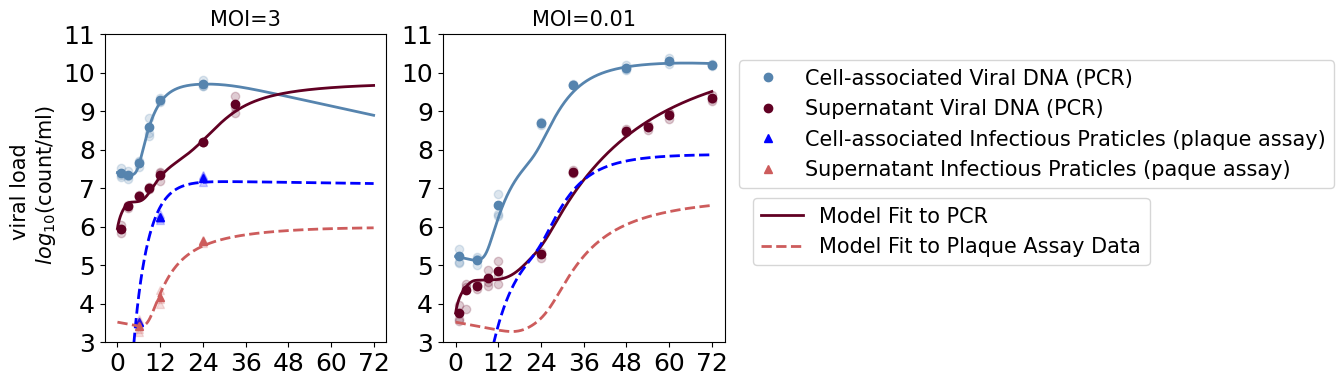

In [50]:
fig = plt.figure(figsize = (8,4))
plt.rcParams.update({'font.size': 18})
for id, idi in zip(IDs_Vero, range(0,len(IDs_Vero))):
    t_Celldata = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PCR_Cell')].time
    temp = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PCR_Cell')].log10_AverVL
    y_Cell_1_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PCR_Cell')].Rep1
    y_Cell_2_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PCR_Cell')].Rep2
    y_Cell_3_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PCR_Cell')].Rep3
    y_Celldata = [float(y) for y in temp]
    
    
    #print(temp)
    t_Supdata = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PCR_Sup')].time
    temp = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PCR_Sup')].log10_AverVL
    y_Sup_1_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PCR_Sup')].Rep1
    y_Sup_2_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PCR_Sup')].Rep2
    y_Sup_3_PCR = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PCR_Sup')].Rep3
    y_Supdata = [float(y) for y in temp]    

    t = np.linspace(0, max(Data_Vero.time), N)
    plt.subplot(1,2,idi+1)
    if idi == 0:
        plt.plot(t_Celldata.values, np.log10(y_Cell_1_PCR),'o', alpha = 0.2,  color = 'xkcd:off blue')
        plt.plot(t_Celldata.values, np.log10(y_Cell_2_PCR),'o', alpha = 0.2,  color = 'xkcd:off blue')
        plt.plot(t_Celldata.values, np.log10(y_Cell_3_PCR),'o', alpha = 0.2,  color = 'xkcd:off blue')
        plt.plot(t_Celldata.values, y_Celldata,'o', color = 'xkcd:off blue', label = 'Cell-associated Viral DNA (PCR)')

   # plt.plot(t,np.log10(V_Cell_I[idi,:]+V_Cell_NI[idi,:]), linewidth = 2, color = 'xkcd:off blue', label = 'no Burst')
        plt.plot(t,np.log10(V_Cell_I_withBurst[idi,:]+V_Cell_NI_withBurst[idi,:]), linewidth = 2, color = 'xkcd:off blue')
    
        plt.plot(t_Supdata.values, np.log10(y_Sup_1_PCR),'o', alpha = 0.2,  color = 'xkcd:burgundy')
        plt.plot(t_Supdata.values, np.log10(y_Sup_2_PCR),'o', alpha = 0.2,  color = 'xkcd:burgundy')
        plt.plot(t_Supdata.values, np.log10(y_Sup_3_PCR),'o', alpha = 0.2,  color = 'xkcd:burgundy')
        plt.plot(t_Supdata.values, y_Supdata,'o', color = 'xkcd:burgundy', label = 'Supernatant Viral DNA (PCR)')

  #  plt.plot(t,np.log10(V_Sup_I[idi,:]+V_Sup_NI[idi,:]),linewidth = 2, color = 'xkcd:burgundy')

        t_Celldata = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PFU_Cell')].time
        temp = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PFU_Cell')].log10_AverVL
        y_Cell_1_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PFU_Cell')].Rep1
        y_Cell_2_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PFU_Cell')].Rep2
        y_Cell_3_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PFU_Cell')].Rep3
        y_Celldata_PFU = [float(y) for y in temp]

        plt.plot(t_Celldata.values, np.log10(y_Cell_1_PFU),'^', alpha = 0.2,  color = 'blue')
        plt.plot(t_Celldata.values, np.log10(y_Cell_2_PFU),'^', alpha = 0.2,  color = 'blue')
        plt.plot(t_Celldata.values, np.log10(y_Cell_3_PFU),'^', alpha = 0.2,  color = 'blue')
        plt.plot(t_Celldata.values, y_Celldata_PFU,'^', color = 'blue',  label = 'Cell-associated Infectious Praticles (plaque assay)')
        
        t_Celldata = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PFU_Sup')].time
        temp = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PFU_Sup')].log10_AverVL
        y_Sup_1_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PFU_Sup')].Rep1
        y_Sup_2_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PFU_Sup')].Rep2
        y_Sup_3_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'PFU_Sup')].Rep3
        y_Supdata_PFU = [float(y) for y in temp]
        
        plt.plot(t_Celldata.values, np.log10(y_Sup_1_PFU),'^', alpha = 0.2,  color = 'indianred')
        plt.plot(t_Celldata.values, np.log10(y_Sup_2_PFU),'^', alpha = 0.2,  color = 'indianred')
        plt.plot(t_Celldata.values, np.log10(y_Sup_3_PFU),'^', alpha = 0.2,  color = 'indianred')
        plt.plot(t_Celldata.values, y_Supdata_PFU,'^', color = 'indianred', label = 'Supernatant Infectious Praticles (paque assay)')      
        plt.plot(t[1:],np.log10(np.maximum(V_Cell_I_withBurst[idi,1:],1)), '--', linewidth = 2, color = 'blue')
        plt.plot(t[1:],np.log10(V_Sup_I_withBurst[idi,1:]), '--', linewidth = 2,  color = 'indianred')
        plt.plot(t,np.log10(V_Sup_I_withBurst[idi,:]+V_Sup_NI_withBurst[idi,:]),linewidth = 2,  color = 'xkcd:burgundy')
        
        plt.legend(fontsize = 15, loc = (2.25,0.5))

        plt.ylabel('viral load \n $log_{10}$(count/ml)',fontsize = 15)
        
    if idi == 1:
        plt.plot(t_Celldata.values, np.log10(y_Cell_1_PCR),'o', alpha = 0.2,  color = 'xkcd:off blue')
        plt.plot(t_Celldata.values, np.log10(y_Cell_2_PCR),'o', alpha = 0.2,  color = 'xkcd:off blue')
        plt.plot(t_Celldata.values, np.log10(y_Cell_3_PCR),'o', alpha = 0.2,  color = 'xkcd:off blue')
        plt.plot(t_Celldata.values, y_Celldata,'o', color = 'xkcd:off blue')
        plt.plot(t,np.log10(V_Cell_I_withBurst[idi,:]+V_Cell_NI_withBurst[idi,:]), linewidth = 2, color = 'xkcd:off blue')
        
        plt.plot(t_Supdata.values, np.log10(y_Sup_1_PCR),'o', alpha = 0.2,  color = 'xkcd:burgundy')
        plt.plot(t_Supdata.values, np.log10(y_Sup_2_PCR),'o', alpha = 0.2,  color = 'xkcd:burgundy')
        plt.plot(t_Supdata.values, np.log10(y_Sup_3_PCR),'o', alpha = 0.2,  color = 'xkcd:burgundy')
        plt.plot(t_Supdata.values, y_Supdata,'o', color = 'xkcd:burgundy')
        
        plt.plot(t,np.log10(V_Sup_I_withBurst[idi,:]+V_Sup_NI_withBurst[idi,:]),linewidth = 2,  color = 'xkcd:burgundy', label = 'Model Fit to PCR')
        plt.plot(t,np.log10(V_Sup_I_withBurst[idi,:]), '--', linewidth = 2,  color = 'indianred', label = 'Model Fit to Plaque Assay Data')
        plt.plot(t[1:],np.log10(np.maximum(V_Cell_I_withBurst[idi,1:],1)), '--', linewidth = 2, color = 'blue')
        plt.legend(fontsize = 15, loc = (1.1,0.25))
    if id == 'High':
        plt.title('MOI=3',fontsize = 15)
    else:
        plt.title('MOI=0.01',fontsize = 15)

        
        
        
        
        
   # plt.plot(t,np.log10(V_Cell_I[idi,:]), linewidth = 2, color = 'blue')
    
    plt.xticks(np.linspace(0,72,7))
        
   # plt.plot(t,np.log10(V_Sup_I[idi,:]), linewidth = 2, color = 'indianred')

    plt.ylim([3, 11])
    plt.xticks(np.linspace(0,72,7))
    plt.yticks(range(3,12))
#plt.tight_layout()
plt.show()
#plt.savefig('Figures/FittoAve_Vero_delta_est_3VirComp_LingapDiff_DDeDiffperIplusE_Vi_Ve_fromData.svg')
#plt.savefig('Figures/FittoAve_Vero_delta_est_3VirComp_LinGapDiff_DDeDiffperIplusE_Vi_Ve_fromData.png')

<Figure size 640x480 with 0 Axes>

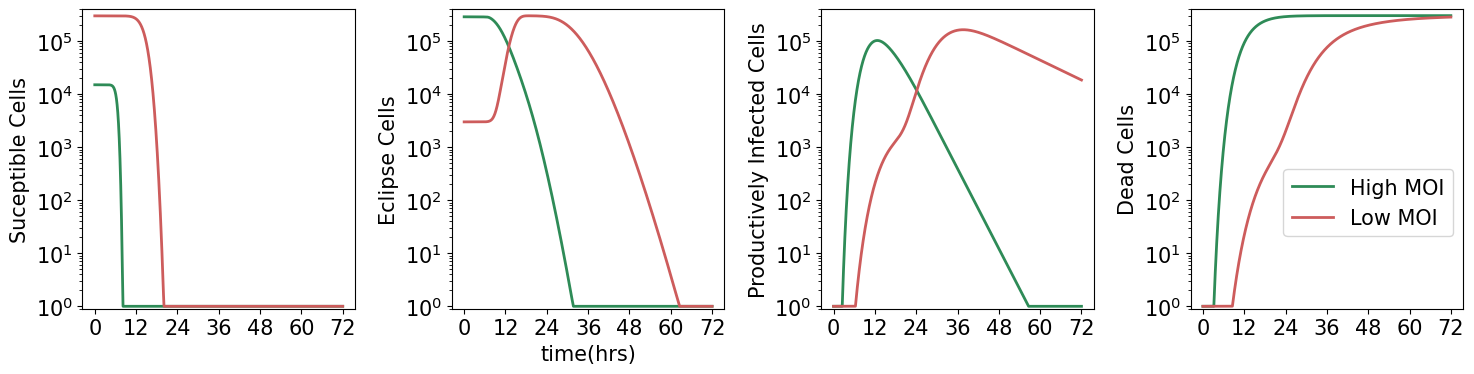

In [54]:
fig = plt.figure(figsize = (15,4))
plt.rcParams.update({'font.size': 15})
E_sum_withBurst = np.sum(E_withBurst, axis = 1)
color = ['seagreen', 'indianred']
for id, idi in zip(IDs_Vero, range(0,len(IDs_Vero))):
    
    
    
    #print(temp)
    

    t = np.linspace(0, max(Data_Vero.time), N)
    plt.subplot(1,4,1)

    plt.semilogy(t,np.maximum(S_withBurst[idi,:],1), color = color[idi], linewidth = 2 )
    #plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.ylim([0.9, 400000])
    plt.xticks(np.linspace(0,72,7))
    plt.ylabel('Suceptible Cells')
    plt.subplot(1,4,2)

    plt.semilogy(t,np.maximum(E_sum_withBurst[idi,:],1), color = color[idi],linewidth = 2)
   # plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.ylim([0.9, 400000])
    plt.xticks(np.linspace(0,72,7))
    plt.ylabel('Eclipse Cells')
    plt.xlabel('time(hrs)')
    plt.subplot(1,4,3)

    plt.semilogy(t,np.maximum(I_DNA_withBurst[idi,:]+I_PFU_withBurst[idi,:],1), color = color[idi],linewidth = 2, label = str(id)+ ' MOI')
    #plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.ylim([0.9, 400000])
    plt.xticks(np.linspace(0,72,7))
    plt.ylabel('Productively Infected Cells')
    plt.subplot(1,4,4)
    plt.semilogy(t,np.maximum(Dead_withBurst[idi,:],1), color = color[idi],linewidth = 2, label = str(id)+ ' MOI')
    #plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.ylim([0.9, 400000])
    plt.xticks(np.linspace(0,72,7))
    plt.ylabel('Dead Cells')
plt.legend(bbox_to_anchor=(1, 0.5))
    
plt.tight_layout()
plt.savefig('Figures/ModelComps.png')
plt.show()
plt.savefig('Figures/FittoAve_Vero_delta_est_3VirComp_LingapDiff_DDeDiffperIplusE_Vi_Ve_fromData.svg')
#plt.savefig('Figures/FittoAve_Vero_delta_est_3VirComp_LinGapDiff_DDeDiffperIplusE_Vi_Ve_fromData.png')

In [56]:
# time at which 95% of the cells are infected
index_95=np.argwhere((S_withBurst[1])<=(0.05*300000))[0]
t[index_95]

array([16.66312663])

In [58]:
# start of second round of infection (when the susceptible cells exit the plateau) High MOI
t_2nd = np.argwhere(S_withBurst[0]<=S_withBurst[0][0]-10000)[0]
t[t_2nd]

array([6.62838628])

In [60]:
# start of second round of infection (when the susceptible cells exit the plateau) Low MOI
t_2nd = np.argwhere(S_withBurst[1]<=S_withBurst[1][0]-100000)[0]
t[t_2nd]

array([13.41085411])

In [62]:
t_18 = np.argwhere(t>=18)[0]
(I_DNA_withBurst[1][t_18]/300000)*100

array([0.1495491])

In [64]:
E_sum_withBurst[1][t_18]/300000

array([0.99094982])

In [66]:
# suceptible cells depletion high MOI
t_depl = np.argwhere(S_withBurst[0]<1)[0]
t[t_depl]

array([8.15768158])

In [68]:
# suceptible cells depletion Low MOI
t_depl = np.argwhere(S_withBurst[1]<1)[0]
t[t_depl]

array([20.06876069])

In [84]:
# all cells are out of eclipse phase
index = np.argwhere(E_sum_withBurst[0]<1)[0]

In [72]:
t[index]

array([31.69183692])

In [76]:
#  all cells are out of eclipse phase
index = np.argwhere(E_sum_withBurst[1]<1)[0]

In [78]:
t[index]

array([62.53550536])

In [82]:
#start of DNA production
index = np.argwhere(I_DNA_withBurst[0]>=1)[0]
t[index]

array([2.54522545])

In [80]:
#start of DNA production
index = np.argwhere(I_DNA_withBurst[1]>=1)[0]
t[index]

array([6.52542525])

In [50]:
#start of PFU production
index = np.argwhere(I_PFU_withBurst[0]>=1)[0]
t[index]

array([3.06147061])

In [86]:
#start of PFU production
index = np.argwhere(I_PFU_withBurst[1]>=1)[0]
t[index]

array([7.2900729])

In [88]:
piI = Indparameters.piPFU_mode
piNI = Data_Vero.piDNA.unique()
pi = [piI, piNI]
Pop_pi_I = Popparameters[Popparameters.parameter=='piPFU_pop'].value[0]
Pop_pi_NI = Data_Vero[Data_Vero.ID == 'High'].piDNA.unique()[0]

Pop_pi = [Pop_pi_I, Pop_pi_NI]
Popparameters

,parameter,value,CV,se_sa,rse_sa,P2.5_sa,P97.5_sa
0,piPFU_pop,23.470000,NaN,NaN,NaN,NaN,NaN
1,DPFU_pop,0.003000,NaN,NaN,NaN,NaN,NaN
2,DDNA_pop,0.047000,NaN,NaN,NaN,NaN,NaN
3,KDNA_pop,6.370000,NaN,NaN,NaN,NaN,NaN
4,gammaPFU_pop,0.040000,NaN,NaN,NaN,NaN,NaN
5,gammaDNA_pop,0.000000,NaN,NaN,NaN,NaN,NaN
6,VSupI0_pop,3334.501811,NaN,561.847163,16.849508,2412.750000,4608.400000
7,betaCell_pop,-4.379989,NaN,0.042578,0.972100,-4.463440,-4.296540
8,lambda_pop,0.532592,NaN,0.114626,21.522223,0.354055,0.801158
9,V_Cell_I0_pop,244.928210,NaN,16.593307,6.774764,214.570000,279.582000


Text(0, 0.5, 'virus production rate \n ($virus$ $cell^{-1}$$hrs^{-1}$)')

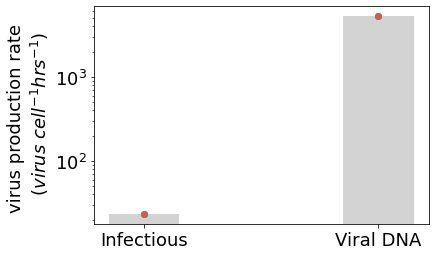

In [24]:
color = ['seagreen', 'indianred']
plt.rcParams.update({'font.size': 18})
plt.semilogy(['Infectious', 'Viral DNA'], [pi[0][0], pi[1][0]], 'o',  label = 'High MOI', color = color[0])
plt.semilogy(['Infectious', 'Viral DNA'], [pi[0][1], pi[1][1]], 'o',  label = 'Low MOI', color = color[1])
#plt.legend()
plt.bar(['Infectious', 'Viral DNA'], Pop_pi, width = 0.3, log = True, color = 'lightgrey')
plt.ylabel('virus production rate \n ($virus$ $cell^{-1}$$hrs^{-1}$)')

In [30]:
DPFU = Indparameters.DPFU_mode
DDNA = Indparameters.DDNA_mode
KDNA = Indparameters.KDNA_mode
EgressI = DPFU
EgressNI_High = DDNA[0]*V_Cell_NI_withBurst[0,:]/(V_Cell_NI_withBurst[0,:]+np.power(10,KDNA[0])*(I_DNA_withBurst[0,:]+I_PFU_withBurst[0,:]))
EgressNI_Low = DDNA[1]*V_Cell_NI_withBurst[1,:]/(V_Cell_NI_withBurst[1,:]+np.power(10,KDNA[1])*(I_DNA_withBurst[1,:]+I_PFU_withBurst[1,:]))


Pop_D_I = Popparameters[Popparameters.parameter=='DPFU_pop'].value[1]
Pop_D_NI = Popparameters[Popparameters.parameter=='DDNA_pop'].value[2]

Pop_D = [Pop_D_I, Pop_D_NI]


(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

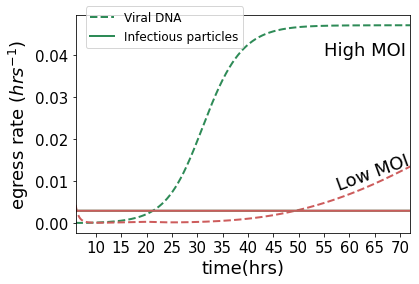

In [54]:
plt.plot(t, EgressNI_High, '--', linewidth = 2,color = color[0], label = 'Viral DNA')
plt.plot(t, EgressNI_Low,  '--', linewidth = 2,color = color[1])
plt.plot(t, DPFU[0]*np.ones(len(t)), linewidth = 2,color = color[0], label = 'Infectious particles')
plt.plot(t, DPFU[1]*np.ones(len(t)),  linewidth = 2,color = color[1])
plt.legend(fontsize = 12, loc=(0.03, 0.85))
plt.text(55,0.04, 'High MOI')
plt.text(57,0.008, 'Low MOI', rotation = 20)
plt.ylabel('egress rate ($hrs^{-1}$)')
plt.xlabel('time(hrs)')
plt.xlim(6,72,5)
plt.xticks([10,15,20, 25,30, 35,40, 45,50, 55,60, 65,70], fontsize = 15)
plt.yticks(fontsize = 15)

In [90]:
# first PFU egress High MOI
index = np.argwhere(I_DNA_withBurst[0]>=1)[0]
highV_sup = V_Sup_I_withBurst[0]
tindex = np.argwhere((np.round(highV_sup[index[0]:]-V_Sup_I_withBurst[0,index]))>=1)[0]
print(t[index[0]+tindex])



[8.05760058]


In [92]:
#First PFU egress low MOI
index = np.argwhere(I_DNA_withBurst[1]>=1)[0]
tindex = np.argwhere((np.round(V_Sup_I_withBurst[1, index[0]:])-np.round(V_Sup_I_withBurst[1,index]))>=1)[0]
t[index+tindex]

array([20.96948969])

In [94]:
# first DNA egress high MOI
index = np.argwhere(I_DNA_withBurst[0]>=1)[0]
tindex = np.argwhere((np.round(V_Sup_NI_withBurst[0, index[0]:])-np.round(V_Sup_NI_withBurst[0,index]))>1)[0]
t[index+tindex]

array([2.54594546])

In [96]:
#first DNA egress low MOI
index = np.argwhere(I_DNA_withBurst[1]>=1)[0]
tindex = np.argwhere((np.round(V_Sup_NI_withBurst[1, index[0]:])-np.round(V_Sup_NI_withBurst[1,index]))>=1)[0]
t[index+tindex]

array([6.52758528])